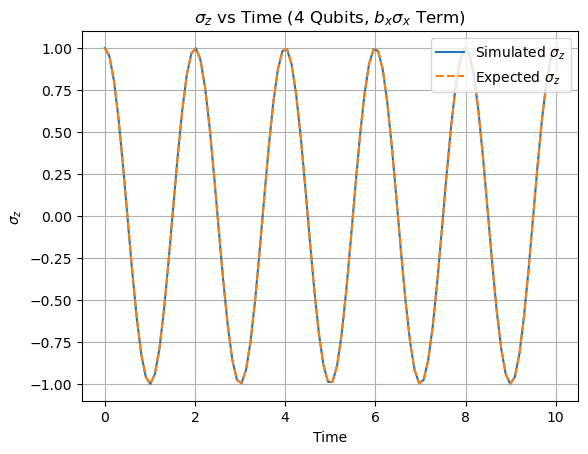

In [4]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import Aer, transpile, assemble
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator

# Constants and simulation parameters
N = 4  # Number of qubits
delta_m_squared = 2 * np.pi
E = 1
omegas = np.array([delta_m_squared / (2 * E) for _ in range(N)])  # omega for each qubit
bs = delta_m_squared / (4 * E)  # b_x for each qubit

# Define the Hamiltonian H for N qubits with only b_x sigma_x terms
H_vac = sum([bs * Pauli(f'{"I"*i}X{"I"*(N-i-1)}').to_matrix() for i in range(N)])

# Create a quantum circuit for the initial state |1100>
qc = QuantumCircuit(N)
qc.x([0, 1])  # Apply X gate to the first and second qubits to create |1100> state
initial_state = Statevector.from_label('1100')

# Define time steps
times = np.linspace(0, 10, 100)  # Extending the time range to 10
sigma_z_values = []

# Simulate the circuit for different time steps
simulator = AerSimulator()

for time in times:
    # Time evolution
    U = Operator(expm(-1j * H_vac * time))
    evolved_state = initial_state.evolve(U)
    
    # Measure expectation value of sigma_z on the first qubit
    z_expectation = evolved_state.expectation_value(Pauli('Z').expand(Pauli('I'*(N-1)))).real
    sigma_z_values.append(z_expectation)

# Calculate expected sigma_z values
expected_sz_array = []
for t in times:
    expected_sz = [np.cos(omega * t) for omega in omegas]
    expected_sz_array.append(np.mean(expected_sz) if expected_sz else None)

# Verify the condition
tolerance = 5e-1
assert all(abs(np.array(sigma_z_values) - np.array(expected_sz_array)) < tolerance), "Assertion failed: values differ more than tolerance"

# Plot the survival probability at site 1 against time
plt.plot(times, sigma_z_values, label='Simulated $\sigma_z$')
plt.plot(times, expected_sz_array, label='Expected $\sigma_z$', linestyle='--')
plt.xlabel('Time')
plt.ylabel('$\sigma_z$')
plt.title('$\sigma_z$ vs Time (4 Qubits, $b_x \sigma_x$ Term)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()



